In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import csv

In [2]:
# Function to load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim=100):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

In [3]:
# Data Loading and Preprocessing with GloVe
def preprocess_data(df, glove_embeddings, embedding_dim=100, max_seq_len=20):
    df = df[['text', 'airline_sentiment']].dropna()

    # Basic sentiment mapping
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

    # Tokenization and vocabulary creation
    def tokenize(text):
        return text.lower().split()

    vocab = Counter()
    for text in df['text']:
        vocab.update(tokenize(text))

    # Create word to index mapping based on available GloVe embeddings
    word_to_idx = {'<UNK>': 0}
    idx = 1
    for word in glove_embeddings.keys():
        if word in vocab:
            word_to_idx[word] = idx
            idx += 1

    # Create embedding matrix with the correct size
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, i in word_to_idx.items():
        if word == '<UNK>':
            continue
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    def text_to_sequence(text):
        return [word_to_idx.get(word, 0) for word in tokenize(text)]

    df['text_seq'] = df['text'].apply(text_to_sequence)
    df['text_seq'] = df['text_seq'].apply(lambda x: x[:max_seq_len] + [0] * (max_seq_len - len(x)))

    # Split dataset into training, validation, and test sets (80-15-5)
    train_data, temp_data = train_test_split(df, test_size=0.20, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=42)

    return train_data, val_data, test_data, embedding_matrix, word_to_idx


In [4]:
class RNN_pytorch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(RNN_pytorch, self).__init__()
        # Define the embedding layer with pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)  # Look up the embeddings
        out, hidden = self.rnn(x)  # Pass through RNN
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out


In [5]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    return accuracy, precision, recall, f1

In [6]:
def train_model_with_metrics(model, train_data, val_data, word_to_idx, epochs=10, learning_rate=0.001, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        y_true_train = []
        y_pred_train = []

        for i, row in train_data.iterrows():
            inputs = torch.tensor(row['text_seq'], dtype=torch.long).unsqueeze(0)
            targets = torch.tensor([row['airline_sentiment']], dtype=torch.long)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_true_train.append(targets.item())
            y_pred_train.append(torch.argmax(outputs, dim=1).item())

        avg_train_loss = total_train_loss / len(train_data)
        train_losses.append(avg_train_loss)

        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(y_true_train, y_pred_train)

        model.eval()
        total_val_loss = 0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for i, row in val_data.iterrows():
                inputs = torch.tensor(row['text_seq'], dtype=torch.long).unsqueeze(0)
                targets = torch.tensor([row['airline_sentiment']], dtype=torch.long)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

                y_true_val.append(targets.item())
                y_pred_val.append(torch.argmax(outputs, dim=1).item())

        avg_val_loss = total_val_loss / len(val_data)
        val_losses.append(avg_val_loss)

        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(y_true_val, y_pred_val)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        print(f"Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, Recall = {train_recall:.4f}, F1 Score = {train_f1:.4f}")
        print(f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}, F1 Score = {val_f1:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "part_1.2_rnn_pytorch.pth")

    return train_losses, val_losses


In [7]:
def evaluate_and_save_results(model, test_data, word_to_idx, output_csv="pytorch_results.csv"):
    sentiment_reverse_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    
    model.eval()
    
    results = []
    y_true_test = []
    y_pred_test = []

    with torch.no_grad():
        for _, row in test_data.iterrows():
            tweet_id = row.get('tweet_id', 'N/A') 
            tweet_text = row['text']
            actual_sentiment = row['airline_sentiment']

            inputs = torch.tensor(row['text_seq'], dtype=torch.long).unsqueeze(0)
            outputs = model(inputs)
            predicted_sentiment = torch.argmax(outputs, dim=1).item()

            # Convert actual and predicted sentiment back to strings
            actual_sentiment_str = sentiment_reverse_mapping[actual_sentiment]
            predicted_sentiment_str = sentiment_reverse_mapping[predicted_sentiment]

            results.append([tweet_id, tweet_text, actual_sentiment_str, predicted_sentiment_str])
            y_true_test.append(actual_sentiment)
            y_pred_test.append(predicted_sentiment)

    # Save results to a CSV
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Tweet Id', 'Tweet Text', 'Actual Sentiment', 'Predicted Sentiment'])
        csv_writer.writerows(results)

    # Calculate and print test metrics
    test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(y_true_test, y_pred_test)
    print(f"Test Metrics: Accuracy = {test_accuracy:.4f}, Precision = {test_precision:.4f}, Recall = {test_recall:.4f}, F1 Score = {test_f1:.4f}")


In [8]:
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt', embedding_dim=100)

# Data loading and preprocessing
df = pd.read_csv('Tweets_q1_main.csv')
train_data, val_data, test_data, embedding_matrix, word_to_idx = preprocess_data(df, glove_embeddings, embedding_dim=100)

Loaded 400000 word vectors from GloVe.


In [9]:
# Model parameters
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_size = 128
output_size = 3

# Create an instance of the RNN model
model = RNN_pytorch(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix)

In [17]:
# print(vocab_size)

7639


In [10]:
# Train the RNN model with metrics
train_losses, val_losses = train_model_with_metrics(model, train_data, val_data, word_to_idx, epochs=50, learning_rate=0.001)

Epoch 1: Train Loss = 0.9602, Val Loss = 0.9722
Training Metrics: Accuracy = 0.5526, Precision = 0.3906, Recall = 0.3704, F1 Score = 0.3515
Validation Metrics: Accuracy = 0.5727, Precision = 0.5241, Recall = 0.3345, F1 Score = 0.2449
Epoch 2: Train Loss = 0.9724, Val Loss = 0.9673
Training Metrics: Accuracy = 0.5549, Precision = 0.3855, Recall = 0.3578, F1 Score = 0.3277
Validation Metrics: Accuracy = 0.5720, Precision = 0.1907, Recall = 0.3333, F1 Score = 0.2426
Epoch 3: Train Loss = 0.9653, Val Loss = 0.9612
Training Metrics: Accuracy = 0.5553, Precision = 0.3911, Recall = 0.3655, F1 Score = 0.3413
Validation Metrics: Accuracy = 0.5460, Precision = 0.3908, Recall = 0.3865, F1 Score = 0.3531
Epoch 4: Train Loss = 0.9190, Val Loss = 0.9743
Training Metrics: Accuracy = 0.5784, Precision = 0.4474, Recall = 0.4155, F1 Score = 0.4117
Validation Metrics: Accuracy = 0.5913, Precision = 0.5940, Recall = 0.3701, F1 Score = 0.3146
Epoch 5: Train Loss = 0.9009, Val Loss = 0.9270
Training Metrics

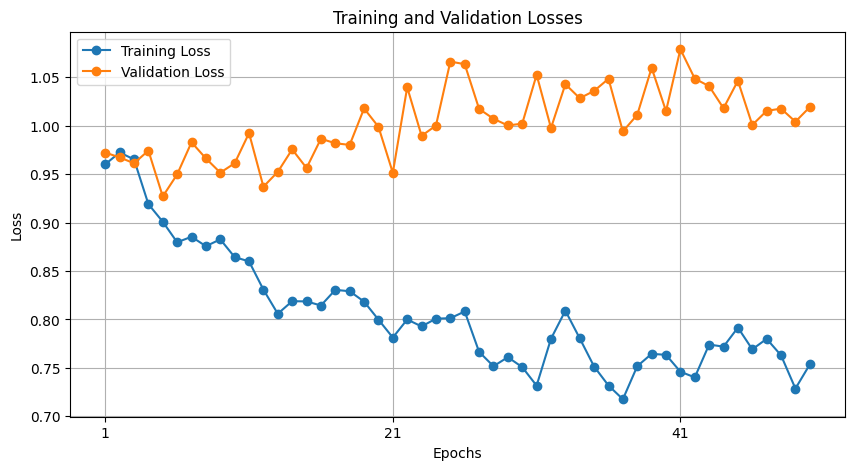

In [11]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

# Add title and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(epochs), 20))  # Set x-ticks to be the epoch numbers
plt.legend()  # Show legend
plt.grid()  # Add grid for better readability

# Show the plot
plt.show()

In [12]:
# Load the best model for evaluation
model.load_state_dict(torch.load("part_1.2_rnn_pytorch.pth"))

# Evaluate the model on training, validation, and test sets and save results for the test set
evaluate_and_save_results(model, test_data, word_to_idx, output_csv="pytorch_results.csv")

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_15000\3363694357.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("part_1.2_rnn_pytorch.pth")

Test Metrics: Accuracy = 0.5940, Precision = 0.4854, Recall = 0.4077, F1 Score = 0.3949


In [13]:
# import pickle

# # Load train and validation losses from the file
# with open('scratch_losses.pkl', 'rb') as f:
#     losses = pickle.load(f)
#     train_scratch_losses = losses['train_losses']
#     val_scratch_losses = losses['val_losses']

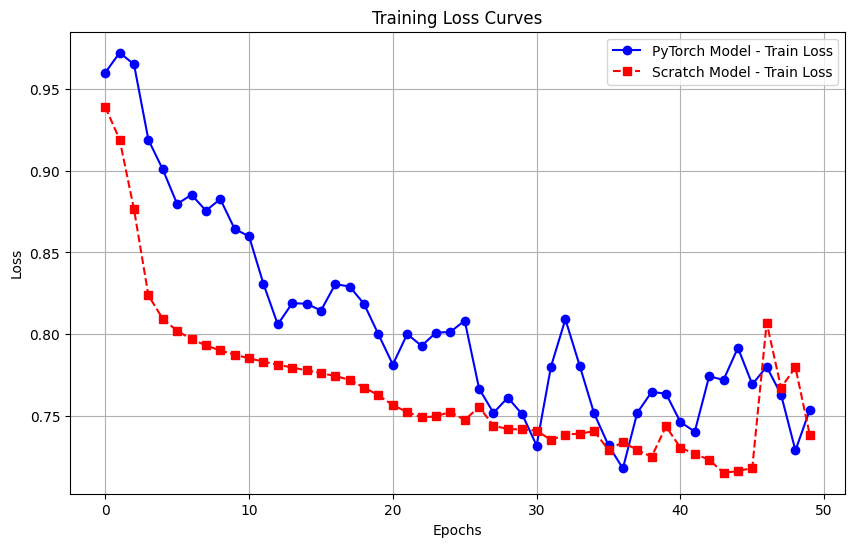

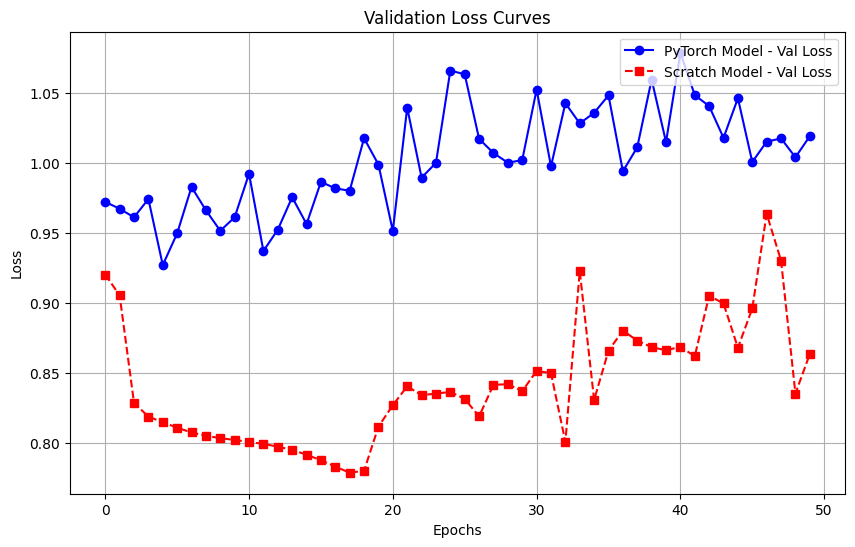

In [14]:
# import matplotlib.pyplot as plt

# # Plot Training Losses
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, marker='o', linestyle='-', color='b', label='PyTorch Model - Train Loss')
# plt.plot(train_scratch_losses, marker='s', linestyle='--', color='r', label='Scratch Model - Train Loss')
# plt.title("Training Loss Curves")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper right')
# plt.grid(True)
# # plt.savefig("training_loss_plot.png")  # Save the plot as an image file
# plt.show()

# # Plot Validation Losses
# plt.figure(figsize=(10, 6))
# plt.plot(val_losses, marker='o', linestyle='-', color='b', label='PyTorch Model - Val Loss')
# plt.plot(val_scratch_losses, marker='s', linestyle='--', color='r', label='Scratch Model - Val Loss')
# plt.title("Validation Loss Curves")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper right')
# plt.grid(True)
# # plt.savefig("validation_loss_plot.png")  # Save the plot as an image file
# plt.show()
